# Simple mean - field inference examples

## Rank-1 Matrix

$$
\begin{align}
S_{ij} &\sim \text{PO}(W_i H^\text{T}_j) \\
W_i &\sim G(a, b) \\
H_j &\sim G(a, b)
\end{align}
$$

$$
\begin{align}
KL(\log q(W,H)||\log p(W,H|S)) = \langle \log q(W,H) \rangle_q - \langle \log p(W,H,S) \rangle_q + \log p(S)
\end{align}
$$

We could find the $q(W,H)$ that minimizes the KL divergence above, or, given that any KL divergence is larger than 0, we could rewrite the expression above as:

$$
\begin{align}
\log p(S) &\geq   \langle \log p(W,H,S) \rangle_q  -\langle \log q(W,H) \rangle_q \\
\log p(S) &\geq   \langle \log p(S|W, H) \rangle_q + \langle \log p(W, H) \rangle_q - \langle \log q(W,H) \rangle_q
\end{align}
$$

Alternatively, we could find the $q(W,H)$ that maximizes the expression above, which is the ELBO.

Given $q(W, H) = q(W)q(H) = \prod_i q_i(W_i) \prod_j q_j(H_j)$, let us maximize ELBO:

$$
\begin{align}
\mathcal{B_p(q)} &= \langle \log p(S|W, H) \rangle_q + \langle \log p(W, H) \rangle_q - \langle \log q(W,H) \rangle_q \\
\mathcal{B_p(q)} &= \sum_{W,H} q(W)q(H)\log p(S|W, H) + \sum_{W,H} q(W)q(H)\log p(W, H) - \sum_{W,H} q(W)q(H)\log q(W) - \sum_{W,H} q(W)q(H)\log q(H) \\
\mathcal{B_p(q)} &= \sum_{W,H} q(W)q(H)\log p(S|W, H) + \sum_{W,H} q(W)q(H)\log p(W, H) - \sum_{W} q(W)\log q(W) - \sum_{H}q(H)\log q(H) \\
\mathcal{B_p(q)} &= \sum_{i,j,W_i,H_j} q_i(W_i)q_j(H_j)\log p(S_{i,j}|W_i, H_j) + \sum_{i,j,W_i,H_j}q_i(W_i)q_j(H_j)(\log p(W_i) + \log p(H_j)) - \sum_{i, W_i} q_i(W_i)\log q_i(W_i) - \sum_{j, H_j}q_j(H_j)\log q_j(H_j)
\end{align}
$$

If we set the derivative of the functional to 0:

$$
\begin{align}
\frac{\delta \mathcal{B_p(q)}}{\delta q_i(W_i)} &=^+ \sum_j \langle \log p(S_{i,j}|W_i, H_j) \rangle_{q_j(H_j)} +\log p(W_i) - log q_i(W_i) -1 \\
0 &=^+ \sum_j \langle \log p(S_{i,j}|W_i, H_j) \rangle_{q_j(H_j)} +\log p(W_i) - log q_i(W_i) -1 \\
log q_i(W_i) &=^+ \sum_j \langle \log p(S_{i,j}|W_i, H_j) \rangle_{q_j(H_j)} +\log p(W_i) \\
log q_i(W_i) &=^+ \sum_j \langle S_{i,j}\log W_i -W_iH_j \rangle_{q_j(H_j)} +(a-1)\log(W_i) - W_i/b \\
log q_i(W_i) &=^+ \log W_i \sum_j S_{i,j} -  W_i\sum_j\langle H_j \rangle_{q_j(H_j)} +(a-1)\log(W_i) - W_i/b \\
log q_i(W_i) &=^+ \log W_i \sum_j S_{i,j} -  W_i\sum_j a^h_j b^h_j +(a-1)\log(W_i) - W_i/b \\
\end{align}
$$ 

These mean that the new distribution for $q_i(W_i)$ is:
$$
q_i(W_i) = \mathcal{G}\big(\sum_{j} (S_{i, j}) + a, b/(b\sum_j a^h_j b^h_j +1)\big)
$$

We will continue updating $q_i(W_i)$'s and $q_j(W_j)$'s similarly until convergence of the ELBO.

Let's generate an example W, H, and S

In [2]:
using Distributions

In [120]:
using PyPlot

In [154]:
a = 5
b = 1
dim_w = 5
dim_h = 3
W = reshape(rand(Gamma(a, b), dim_w), (dim_w,1));
H = reshape(rand(Gamma(a, b), dim_h), (dim_h,1));
P = W * H'
S = zeros((length(W), length(H)))
for i in 1:dim_w
    for j in 1:dim_h
        S[i, j] = rand(Poisson(P[i,j]))
    end
end

In [156]:
phi_W = rand(dim_w,2);
phi_H = rand(dim_h,2);
before_tr = (phi_W[:,1] .* phi_W[:,2])*(phi_H[:,1] .* phi_H[:,2])';

In [157]:
vmax = 1. *maximum(S)
vmin = 0;

In [158]:
println("beginning error: ", norm(S - (phi_W[:,1] .* phi_W[:,2])*(phi_H[:,1] .* phi_H[:,2])'))
for i in 1:200
    global phi_W, phi_H
    phi_W = hcat(sum(S, dims=2) .+ a, b./ fill((b*sum(phi_W[:,1].*phi_W[:,2])+1),dim_w))
    phi_H = hcat(sum(S, dims=1)' .+ a, b./ fill((b*sum(phi_H[:,1].*phi_H[:,2])+1),dim_h))
    #println("training error: ", norm(S - (phi_W[:,1] .* phi_W[:,2])*(phi_H[:,1] .* phi_H[:,2])'))
end
println("final error: ", norm(S - (phi_W[:,1] .* phi_W[:,2])*(phi_H[:,1] .* phi_H[:,2])'))

beginning error: 104.49503636180164
final error: 11.425723187568924


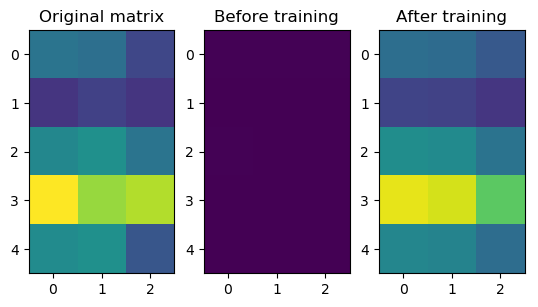

PyObject Text(0.5,1,'After training')

In [159]:
PyPlot.subplot(1,3,1)
PyPlot.imshow(S, vmin=vmin, vmax=vmax)
PyPlot.title("Original matrix")
PyPlot.subplot(1,3,2)
PyPlot.imshow(before_tr, vmin=vmin, vmax=vmax);
PyPlot.title("Before training")
PyPlot.subplot(1,3,3)
PyPlot.imshow((phi_W[:,1] .* phi_W[:,2])*(phi_H[:,1] .* phi_H[:,2])', vmin=vmin, vmax=vmax);
PyPlot.title("After training")

## Scalar

$$
\begin{align}
S &\sim \text{PO}(WH) \\
W &\sim G(a, b) \\
H &\sim G(a, b)
\end{align}
$$

$$
\begin{align}
KL(\log q(W,H)||\log p(W,H|S)) = \langle \log q(W,H) \rangle_q - \langle \log p(W,H,S) \rangle_q + \log p(S)
\end{align}
$$

We could find the $q(W,H)$ that minimizes the KL divergence above, or, given that any KL divergence is larger than 0, we could rewrite the expression above as:

$$
\begin{align}
\log p(S) &\geq   \langle \log p(W,H,S) \rangle_q  -\langle \log q(W,H) \rangle_q \\
\log p(S) &\geq   \langle \log p(S|W, H) \rangle_q + \langle \log p(W, H) \rangle_q - \langle \log q(W,H) \rangle_q
\end{align}
$$

Alternatively, we could find the $q(W,H)$ that maximizes the expression above, which is the ELBO.

Given $q(W, H) = q(W)q(H)$ let us maximize ELBO:

$$
\begin{align}
\mathcal{B_p(q)} &= \langle \log p(S|W, H) \rangle_q + \langle \log p(W, H) \rangle_q - \langle \log q(W,H) \rangle_q \\
\mathcal{B_p(q)} &= \sum_{W,H} q(W)q(H)\log p(S|W, H) + \sum_{W,H} q(W)q(H)\log p(W, H) - \sum_{W,H} q(W)q(H)\log q(W) - \sum_{W,H} q(W)q(H)\log q(H) \\
\mathcal{B_p(q)} &= \sum_{W,H} q(W)q(H)\log p(S|W, H) + \sum_{W} q(W)\log p(W) + \sum_{H} q(H)\log p(H) - \sum_{W} q(W)\log q(W) - \sum_{H}q(H)\log q(H) \\
\end{align}
$$

If we set the derivative of the functional to 0:

$$
\begin{align}
\frac{\delta \mathcal{B_p(q)}}{\delta q(W)} &=^+ \langle \log p(S|W, H) \rangle_{q(H)} +\log p(W) - log q(W) -1 \\
0 &=^+  \langle \log p(S|W, H) \rangle_{q(H)} +\log p(W) - log q(W) -1 \\
log q(W) &=^+  \langle \log p(S|W, H) \rangle_{q(H)} +\log p(W)\\
log q(W) &=^+ S\log W -W\langle H \rangle_{q(H)} +(a-1)\log(W) - W/b \\
log q(W) &=^+ S\log W -W a_hb_h +(a-1)\log(W) - W/b \\
\end{align}
$$ 

These mean that the new distribution for $q_i(W_i)$ is:
$$
q(W) = \mathcal{G}\big(S + a, b/(a_hb_hb+1)\big)
$$

We will continue updating $q_i(W_i)$'s and $q_j(W_j)$'s similarly until convergence of the ELBO.

Let's generate an example W, H, and S

In [24]:
a = 5
b = 1;

In [25]:
W = rand(Gamma(a, b));
H = rand(Gamma(a, b));
S = W*H

17.850522597527235

In [26]:
a_w, b_w = rand(2);
a_h, b_h = rand(2);

In [27]:
println(string("error before variational inference: ", abs(S - a_w*b_w*a_h*b_h)))
no_epochs= 50
errors = zeros(no_epochs)
for i in 1:no_epochs
    global a_w, b_w, a_h, b_h
    a_w, b_w = S + a, b/(b*a_h*b_h + 1)
    a_h, b_h = S + a, b/(b*a_w*b_w + 1)
    errors[i] = abs(S - a_w*b_w*a_h*b_h)
end
println(string("error after variational inference: ", abs(S - a_w*b_w*a_h*b_h)))

error before variational inference: 17.849462392168274
error after variational inference: 0.6936997038128396


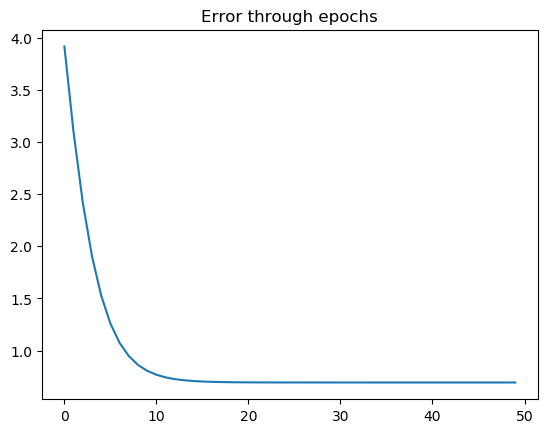

In [28]:
PyPlot.plot(errors)
PyPlot.title("Error through epochs");